In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import skimage.measure

In [2]:
path_root = "/home/arnab/MEGAsync/Research/Attention Tracking/Eye Tracking/Data_Backup/saved_sessions_latest/"

In [3]:
with open("session_track.json", 'r') as f:
    session_track = json.load(f)
session_track

{'template': {'glass': 0,
  'gender': 'male',
  'brightness': -1,
  'camera_res': {'mega_pixels': 2, 'frame_per_second': 30},
  'sessions': {'Position 1': '',
   'Position 2': '',
   'Position 3': '',
   'Position 4': '',
   'Position 5': '',
   'Position 6': '',
   'Position 7': '',
   'Position 8': '',
   'Position 9': '',
   'Right': '',
   'Left': '',
   'Up': '',
   'Down': '',
   'Blink': ''}},
 'P0': {'glass': 0,
  'gender': 'male',
  'brightness': -1,
  'camera_res': {'mega_pixels': 2, 'frame_per_second': 30},
  'sessions': {'Position 1': 'session_2021-09-24T10:09:59.226067.json',
   'Position 2': 'session_2021-09-24T10:10:40.966059.json',
   'Position 3': 'session_2021-09-24T10:11:12.264553.json',
   'Position 4': 'session_2021-09-24T10:11:40.039892.json',
   'Position 5': 'session_2021-09-24T10:12:05.820481.json',
   'Right': 'session_2021-09-24T10:13:07.759221.json',
   'Left': 'session_2021-09-24T10:13:32.368622.json',
   'Up': 'session_2021-09-24T10:13:59.251024.json',
   

In [4]:
def getSecondFromTimeStamp(timestamp):
    return timestamp["hour"]*60*60 + timestamp["minute"]*60 + timestamp["seconds"]


def gaze__processOneSession(gaze_arr, latest = None):
    xrr = []
    yrr = []
    if(latest != None and len(gaze_arr) > 0):
        endtime = getSecondFromTimeStamp(gaze_arr[-1]["timestamp"])
    for gaze in gaze_arr:
        if(latest != None):
            curr_time = getSecondFromTimeStamp(gaze["timestamp"])
            if(endtime - curr_time > latest):
                continue
        xrr.append(gaze["gaze"]["x"])
        yrr.append(gaze["gaze"]["y"])
    return np.array(xrr), np.array(yrr)


def loadjson_singleSession(session_name):
    session_name = session_name.replace(":", "%3a")
    folder = session_name.split('.json')[0]
    with open(path_root + folder + "/" + session_name, 'r') as f:
        session = json.load(f)
        if(len(session.keys()) != 1):
            print("{} session has {} ids".format(session_name, len(session.keys())))
        ret_session = []
        ret_len = 0
        for id in session:
            if(len(session[id]) > ret_len):
                ret_len = len(session[id])
                ret_session = session[id]
        return ret_session


def calculate_MSE(xrr, yrr, marker_x, marker_y):
    ret = 0
    for idx in range(xrr.shape[0]):
        ret += (marker_x - xrr[idx])**2 + (marker_y - yrr[idx])**2
    return ret/xrr.shape[0]

In [5]:
def truncate_array(array, min_val = 0, max_val = 1):
    ret = []
    for val in array:
        v = max(val, min_val)
        v = min(v, max_val)
        ret.append(v)
    return np.array(ret)

In [6]:
not_valid = ["template", "P0", "P0_", "P17"]

def loadjson__multileSession(position_filters, time_limit = 15, _filter = {"glass": -1, "gender": -1, "brightness": -1, "camera_res": -1}):
    combined_xrr = np.array([])
    combined_yrr = np.array([])
    individual_mse = []
    counter = 0

    if(type(position_filters) != list):
        position_filters = [position_filters]
    
    for position_key in position_filters:
        for participant in session_track:
            # print(" >> ", participant, " -- glass:", session_track[participant]["glass"])
            if participant in not_valid:
                continue
            # if glass != -1 and session_track[participant]["glass"] != glass:
            #     continue
            skip = False
            for key in _filter:
                if(key != "camera_res"):
                    val = session_track[participant][key]
                else:
                    val = session_track[participant]["camera_res"]["mega_pixels"]
                    if(val == -1):
                        skip = True
                        break
                    val = round(val, 1)
                    
                # print(key, " >> ", _filter[key], " <><> ", val)
                if(_filter[key] != -1 and val != _filter[key]):
                    skip = True
                    break

            if(skip):
                continue
            # print(" >> ", participant, " -- glass:", session_track[participant]["glass"], end=" <> ")
            
            json_session = loadjson_singleSession(session_track[participant]['sessions'][position_key])
            xrr, yrr = gaze__processOneSession(json_session, time_limit)
            xrr = truncate_array(xrr)
            yrr = truncate_array(yrr)
            # print("Shape: ", xrr.shape, yrr.shape)
            if(len(xrr) > 0):
                individual_mse.append(calculate_MSE(xrr, yrr, marker_track[position_key][0], marker_track[position_key][1]))
            else:
                continue
            combined_xrr = np.concatenate((combined_xrr, xrr))
            combined_yrr = np.concatenate((combined_yrr, yrr))
            counter += 1
     
    print("Found {} participants >> Combined shape".format(counter), combined_xrr.shape, combined_yrr.shape)
    return combined_xrr, combined_yrr, individual_mse, counter

In [7]:
session_name = "session_2021-09-24T10:09:59.226067/session_2021-09-24T10:09:59.226067.json"
session_name = session_name.replace(":", "%3a")
with open(path_root + session_name, 'r') as f:
    session = json.load(f)

In [8]:
xrr, yrr = gaze__processOneSession(session['hdehheeafrlqlylodn58si'], 10)
xrr.shape, yrr.shape

((124,), (124,))

In [9]:
accuracy_cords = [
    {'x': 50, 'y': 50},
    {'x': 10, 'y': 10},
    {'x': 10, 'y': 50},
    {'x': 10, 'y': 90},
    {'x': 50, 'y': 10},
    {'x': 50, 'y': 90},
    {'x': 90, 'y': 10},
    {'x': 90, 'y': 50},
    {'x': 90, 'y': 90},
]

marker_track = {}
for i in range(len(accuracy_cords)):
    marker_track["Position {}".format(i+1)] = [accuracy_cords[i]['x']/100, accuracy_cords[i]['y']/100]

print(len(marker_track.keys()))
marker_track

9


{'Position 1': [0.5, 0.5],
 'Position 2': [0.1, 0.1],
 'Position 3': [0.1, 0.5],
 'Position 4': [0.1, 0.9],
 'Position 5': [0.5, 0.1],
 'Position 6': [0.5, 0.9],
 'Position 7': [0.9, 0.1],
 'Position 8': [0.9, 0.5],
 'Position 9': [0.9, 0.9]}

In [10]:
def plotHeatmap(xrr, yrr, subplot):
    heat_map = np.zeros((1001, 1001))
    for idx in range(xrr.shape[0]):
        xx = int(round(xrr[idx]*1000))
        xx = max(xx, 0)
        xx = min(xx, 1000)

        yy = int(round(yrr[idx]*1000))
        yy = max(yy, 0)
        yy = min(yy, 1000)
        try:
            heat_map[yy, xx] += 1
        except:
            print(f"{yy}({yrr[idx]}), {xx}({xrr[idx]})")
            # return
    # print("heatmap shape", heat_map.shape)
    heatmap_reduced = skimage.measure.block_reduce(heat_map, (100,100), np.mean)
    # print(heatmap_reduced.shape, heatmap_reduced.min(), heatmap_reduced.max())
    subplot.pcolormesh(np.arange(11), np.arange(11), heatmap_reduced, 
                    shading='gouraud', 
                    vmin=heatmap_reduced.min(), 
                    vmax=heatmap_reduced.max())
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.invert_yaxis()

In [11]:
position = "Position 9"
xrr, yrr, ind_mse, counter = loadjson__multileSession(position)

session_2021-10-02T10%3a16%3a34.642542.json session has 2 ids
session_2021-10-04T02%3a40%3a07.729511.json session has 2 ids
Found 31 participants >> Combined shape (6184,) (6184,)


/home/arnab/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


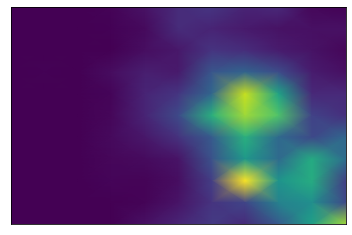

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plotHeatmap(xrr, yrr, ax)
fig.show()

In [13]:
def check_cohesiveness(xrr, yrr):
    diff_x = xrr.mean() - xrr
    diff_y = yrr.mean() - yrr
    sum_dist = 0
    for x,y in zip(diff_x, diff_y):
        sum_dist += x*x + y*y
    mean_dist = sum_dist/xrr.shape[0]

    return mean_dist

In [14]:
def merge_gaze_points(xrr1, yrr1, xrr2, yrr2):
    xrr = np.concatenate((xrr1, xrr2))
    yrr = np.concatenate((yrr1, yrr2))

    order = np.arange(xrr.shape[0])
    np.random.shuffle(order)
    ret_x = []
    ret_y = []
    for o in order:
        ret_x.append(xrr[o])
        ret_y.append(yrr[o])
    
    return np.array(ret_x), np.array(ret_y)

In [15]:
def getCompareFig(xrr_lft, yrr_lft, xrr_rgt, yrr_rgt):
    plt.rcParams["figure.figsize"] = (10, 4)
    fig, ax = plt.subplots(nrows=1, ncols=2)
    plotHeatmap(xrr_lft, yrr_lft, ax[0])
    plotHeatmap(xrr_rgt, yrr_rgt, ax[1])

    return fig

Loading Data of Position 2 ... 
session_2021-10-02T09%3a45%3a34.906832.json session has 2 ids
session_2021-10-02T10%3a11%3a51.061924.json session has 2 ids
session_2021-10-04T02%3a36%3a38.093949.json session has 2 ids
session_2021-10-05T08%3a56%3a54.162246.json session has 2 ids
Found 31 participants >> Combined shape (6049,) (6049,)
Loaded data ---  (6049,)
Generating Random Sample
Plotting Side/Side comparison -- Whole Sample
-------------------------------------------------
Cohesiveness -- Mean Square Error with the Mean
Focus:  0.06303481052782117
Random:  0.16547155644013628
Difference:  0.10243674591231511
-------------------------------------------------


/home/arnab/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


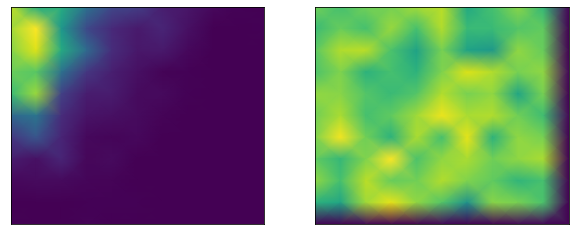

In [65]:
position = "Position 2"


num_runs = 5
num_points = 500


min_val = 0
max_val = 1
run_track = []

print(f"Loading Data of {position} ... ")
xrr, yrr, ind_mse, counter = loadjson__multileSession(position)
print("Loaded data --- ", xrr.shape)

print("Generating Random Sample")
rand_x = np.random.uniform(min_val, max_val, len(xrr))
rand_y = np.random.uniform(min_val, max_val, len(yrr))
print("Plotting Side/Side comparison -- Whole Sample")
fig = getCompareFig(xrr, yrr, rand_x, rand_y)
fig.show()

coh = check_cohesiveness(xrr, yrr)
rand_coh = check_cohesiveness(rand_x, rand_y)
diff_coh = rand_coh - coh
print("-------------------------------------------------")
print("Cohesiveness -- Mean Square Error with the Mean")
print("Focus: ", coh)
print("Random: ", rand_coh)
print("Difference: ", diff_coh)
print("-------------------------------------------------")

In [66]:
num_runs = 5000
num_points = 5000
run_track = []

sample_space_x, sample_space_y = merge_gaze_points(xrr, yrr, rand_x, rand_y)
print(sample_space_x.shape, sample_space_y.shape)

for run in range(num_runs):
    print(f"------------------- RUN {run+1}/{num_runs} -------------------")
    cur_sample_1 = np.random.choice(np.arange(sample_space_x.shape[0]), num_points)
    xrr_lft = []
    yrr_lft = []
    for o in cur_sample_1:
        xrr_lft.append(sample_space_x[o])
        yrr_lft.append(sample_space_y[o])
    xrr_lft, yrr_lft = np.array(xrr_lft), np.array(yrr_lft)
    
    cur_sample_2 = np.random.choice(np.arange(sample_space_x.shape[0]), num_points)
    xrr_rgt = []
    yrr_rgt = []
    for o in cur_sample_2:
        xrr_rgt.append(sample_space_x[o])
        yrr_rgt.append(sample_space_y[o])
    xrr_rgt, yrr_rgt = np.array(xrr_rgt), np.array(yrr_rgt)

    coh_lft = check_cohesiveness(xrr_lft, yrr_lft)
    coh_rgt = check_cohesiveness(xrr_rgt, yrr_rgt)
    cur_diff = abs(coh_lft - coh_rgt)
    print(f"Cohesiveness ==> {coh_lft} - {coh_rgt} => |{cur_diff}|")
    run_track.append(cur_diff)
    print("-------------------------------------------------")

    # fig = getCompareFig(xrr_lft, yrr_lft, xrr_rgt, yrr_rgt)
    # fig.show()

(12098,) (12098,)
------------------- RUN 1/5000 -------------------
Cohesiveness ==> 0.149584486811615 - 0.15126137062835623 => |0.001676883816741248|
-------------------------------------------------
------------------- RUN 2/5000 -------------------
Cohesiveness ==> 0.15025261143367957 - 0.14993924767332326 => |0.00031336376035631663|
-------------------------------------------------
------------------- RUN 3/5000 -------------------
Cohesiveness ==> 0.15170187533753673 - 0.14430327690195827 => |0.007398598435578468|
-------------------------------------------------
------------------- RUN 4/5000 -------------------
Cohesiveness ==> 0.14952518811064516 - 0.14985267640929095 => |0.00032748829864578943|
-------------------------------------------------
------------------- RUN 5/5000 -------------------
Cohesiveness ==> 0.1502040060866782 - 0.14827361940184886 => |0.0019303866848293383|
-------------------------------------------------
------------------- RUN 6/5000 -------------------

In [67]:
run_track = np.array(run_track)
print(f"{diff_coh} -- {run_track.mean()}")

0.10243674591231511 -- 0.0020293319215689797


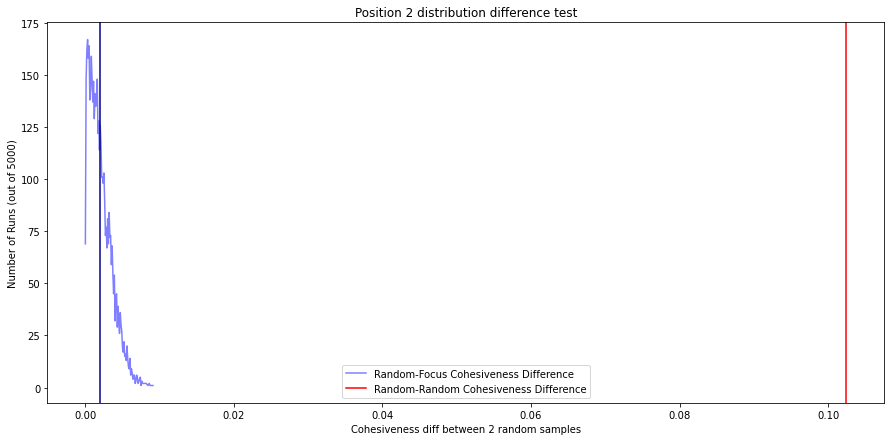

In [73]:
freq = {}
for val in np.round(run_track, 4):
    if(val not in freq):
        freq[val] = 0
    freq[val] += 1

x_vals = sorted(list(freq.keys()))
y_vals = [freq[x] for x in x_vals]

def set_box_color(bp, color):
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[item], color=color)

plt.rcParams["figure.figsize"] = (15, 7)
plt.plot(x_vals, y_vals, color = 'blue', alpha = 0.5, label = "Random-Focus Cohesiveness Difference")
plt.axvline(x=diff_coh, color = 'red', label = "Random-Random Cohesiveness Difference")
plt.axvline(x=np.array(run_track).mean(), color = 'darkblue')
plt.legend()
plt.xlabel("Cohesiveness diff between 2 random samples")
plt.ylabel(f"Number of Runs (out of {num_runs})")
plt.title(f"{position} distribution difference test")
plt.show()